In [150]:
from os import walk
from os import listdir

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
is_demo = True
data_path = "example_data/" if is_demo else "../lataus/data/lam/"

available_years = listdir(data_path)
print(f"Available years {', '.join(available_years)}.")

Available years 2016.


In [3]:
selected_year = "2016"

available_elys = listdir(data_path + selected_year)
print(f"Available ELY codes are {', '.join(available_elys)}.")

Available ELY codes are .ipynb_checkpoints, 01.


In [4]:
selected_ely = "01"

available_lam_files = listdir(data_path + selected_year + "/" + selected_ely)

def get_lam_id(file_name):
    end_of_id = file_name.index("_", 7)
    return file_name[7:end_of_id]

available_lams = set()
for file_name in available_lam_files:
    available_lams.add(get_lam_id(file_name))

print(f"Available lams are {', '.join(sorted(available_lams))}.")

Available lams are 1.


In [5]:
column_names = ["pistetunnus", "vuosi", "päivän järjestysnumero", "tunti", "minuutti", "sekunti", "sadasosasekunti", "pituus (m)", "kaista", "suunta", "ajoneuvoluokka", "nopeus (km/h)", "faulty", "kokonaisaika ", "aikaväli ", "jonoalku "]

df = pd.read_csv(f"{data_path}{selected_year}/{selected_ely}/{available_lam_files[0]}", sep=";", names=column_names)

In [6]:
print(f"df from: {data_path}{selected_year}/{selected_ely}/{available_lam_files[0]}")

df from: example_data/2016/01/lamraw_1_16_1.csv


In [7]:
def divide_to_bins(df, minute_interval):
    interval = np.arange(0, 61, minute_interval)
    cut = pd.cut(df["minuutti"], interval, include_lowest=True)
    grouped = df.groupby(["tunti", cut, "suunta"])
    return (grouped, interval)

In [8]:
grouped_df, interval = divide_to_bins(df, 5)

In [9]:
# halutut tiedot <LAMid, suunta, aikaindeksi, tavaralkm, tavaraV, hlölkm, hlöV, tavara pituus>

In [144]:
cargo_ids = [2,4,5]
car_ids = [1,3,6,7]

def create_data_file(dataframe, interval_in_minutes):
    grouped, interval = divide_to_bins(dataframe, interval_in_minutes)
    lam_id = dataframe["pistetunnus"].min()
    year = dataframe["vuosi"].min()
    day = dataframe["päivän järjestysnumero"].min()
    direction = grouped["suunta"].max()
    cargo_group = get_vehicle_class_rows(grouped, cargo_ids)
    car_group = get_vehicle_class_rows(grouped, car_ids)
    
    result = pd.DataFrame({
        "lamid": lam_id,
        "year": year,
        "day": day,
        "speed_cargo": speed_sum(cargo_group),
        "speed_car": speed_sum(car_group),
        "count_car": vehicle_count(car_group),
        "count_cargo": vehicle_count(cargo_group),
    }).reset_index()
    
    result = add_minute_index(result)
    result = result.rename(columns={"tunti": "hour", "suunta": "direction"})
    
    return result

# Will return only the rows which are in intreset for now...
def get_vehicle_class_rows(df, vehicle_classes):
    return df.apply(lambda x: x[x['ajoneuvoluokka'].isin(vehicle_classes)])[["nopeus (km/h)", "pituus (m)"]].groupby(["tunti", "minuutti", "suunta"])

def add_minute_index(df):
    df["minuutti"] = df["minuutti"].apply(lambda x: x.right / 5 - 1).astype({"minuutti": int})
    df = df.rename(columns={"minuutti": "minute_index"})
    return df    

def get_minute_indices(df):
    return pd.DataFrame(df).reset_index()[0].apply(lambda x: x[1].right / 5 - 1)

def vehicle_count(df):
    return df.size()

def speed_sum(df):
    return df['nopeus (km/h)'].sum()

def minutes(df, interval):
    return (df["minuutti"].max() / interval - 1).round()

def hours(df):
    return grouped_df["tunti"].min()

def cargo_length(df):
    return df.apply(lambda x: x[x['ajoneuvoluokka'].isin([2,4,5])]['pituus (m)'].sum())

In [139]:
new_df = create_data_file(df, 5)

In [149]:
dir1 = new_df.loc[new_df["direction"]==1]

In [157]:
new_df["time_index"] = new_df["hour"] * 60 / 5 + new_df["minute_index"]

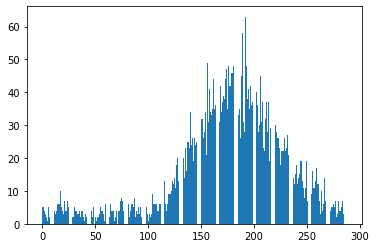

In [164]:
fig, ax = plt.subplots()
rects1 = ax.bar(new_df.time_index, new_df.count_car, label='Suunta 1')

In [167]:
dir1.loc[dir1["count_car"] == 0].loc[dir1["count_car"] == 0]

,hour,minute_index,direction,lamid,year,day,speed_cargo,speed_car,count_car,count_cargo
40,1,8,1,1,16,1,0,0,0,0
72,3,0,1,1,16,1,0,0,0,0
80,3,4,1,1,16,1,0,0,0,0
98,4,1,1,1,16,1,0,0,0,0
102,4,3,1,1,16,1,86,0,0,1
122,5,1,1,1,16,1,0,0,0,0
128,5,4,1,1,16,1,0,0,0,0
136,5,8,1,1,16,1,0,0,0,0
142,5,11,1,1,16,1,0,0,0,0
160,6,8,1,1,16,1,0,0,0,0
